# Assignment 4: Generative Models with GAN/cGAN

**Course:** Deep Learning  
**Dataset:** Adult (Census Income)  
**Task:** Implement GAN and Conditional GAN for synthetic tabular data generation

---

## 1. Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

Using device: cuda


## 2. Data Loading and Preprocessing

### 2.1 Load ARFF File

In [2]:
# Load the Adult dataset from ARFF file
data, meta = arff.loadarff('adult.arff')
df = pd.DataFrame(data)

# Decode byte strings to regular strings
for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].str.decode('utf-8')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn types:")
print(df.dtypes)
print(f"\nFirst few rows:")
df.head()

Dataset shape: (32561, 15)

Column types:
age               float64
workclass          object
fnlwgt            float64
education          object
education-num     float64
marital-status     object
occupation         object
relationship       object
race               object
sex                object
capital-gain      float64
capital-loss      float64
hours-per-week    float64
native-country     object
income             object
dtype: object

First few rows:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [3]:
# Check for missing values (represented as '?')
print("Missing values ('?') per column:")
for col in df.columns:
    if df[col].dtype == object:
        missing_count = (df[col] == '?').sum()
        if missing_count > 0:
            print(f"  {col}: {missing_count} ({missing_count/len(df)*100:.2f}%)")

Missing values ('?') per column:
  workclass: 1836 (5.64%)
  occupation: 1843 (5.66%)
  native-country: 583 (1.79%)


### 2.2 Preprocessing

**Preprocessing decisions:**
1. **Missing values**: Impute using mode for categorical features (most frequent value)
2. **Skewed features**: Log transform (log1p) for `capital-gain` and `capital-loss` to handle zero-inflation
3. **Continuous features**: Min-Max scaling to [0, 1] range (after log transform)
4. **Categorical features**: One-hot encoding

In [4]:
# Define feature types
CONTINUOUS_COLS = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
CATEGORICAL_COLS = ['workclass', 'education', 'marital-status', 'occupation', 
                    'relationship', 'race', 'sex', 'native-country']
TARGET_COL = 'income'

print(f"Continuous features ({len(CONTINUOUS_COLS)}): {CONTINUOUS_COLS}")
print(f"Categorical features ({len(CATEGORICAL_COLS)}): {CATEGORICAL_COLS}")
print(f"Target: {TARGET_COL}")

Continuous features (6): ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical features (8): ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Target: income


In [5]:
class DataPreprocessor:
    """Preprocessor for Adult dataset with imputation, log transform, and encoding."""
    
    def __init__(self, continuous_cols, categorical_cols, target_col):
        self.continuous_cols = continuous_cols
        self.categorical_cols = categorical_cols
        self.target_col = target_col
        self.scaler = MinMaxScaler()
        self.label_encoder = LabelEncoder()
        self.category_mappings = {}  # Store one-hot mappings
        self.category_dims = {}  # Store dimensions for each categorical feature
        self.mode_values = {}  # Store mode for imputation
        
        # Skewed columns that need log transform (high proportion of zeros)
        self.skewed_cols = ['capital-gain', 'capital-loss']
        
    def fit(self, df):
        """Fit the preprocessor on training data."""
        df = df.copy()
        
        # Store mode values for imputation
        for col in self.categorical_cols:
            # Get mode excluding '?'
            valid_values = df[df[col] != '?'][col]
            self.mode_values[col] = valid_values.mode()[0]
        
        # Impute missing values
        for col in self.categorical_cols:
            df[col] = df[col].replace('?', self.mode_values[col])
        
        # Apply log transform to skewed columns before fitting scaler
        for col in self.skewed_cols:
            if col in self.continuous_cols:
                df[col] = np.log1p(df[col])  # log(1+x) handles zeros gracefully
        
        # Fit scaler on continuous features (now with log-transformed skewed cols)
        self.scaler.fit(df[self.continuous_cols])
        
        # Fit label encoder on target
        self.label_encoder.fit(df[self.target_col])
        
        # Store category mappings for one-hot encoding
        for col in self.categorical_cols:
            unique_values = sorted(df[col].unique())
            self.category_mappings[col] = {v: i for i, v in enumerate(unique_values)}
            self.category_dims[col] = len(unique_values)
        
        return self
    
    def transform(self, df):
        """Transform data using fitted preprocessor."""
        df = df.copy()
        
        # Impute missing values
        for col in self.categorical_cols:
            df[col] = df[col].replace('?', self.mode_values[col])
        
        # Apply log transform to skewed columns
        for col in self.skewed_cols:
            if col in self.continuous_cols:
                df[col] = np.log1p(df[col])
        
        # Scale continuous features
        continuous_data = self.scaler.transform(df[self.continuous_cols])
        
        # One-hot encode categorical features
        categorical_data = []
        for col in self.categorical_cols:
            one_hot = np.zeros((len(df), self.category_dims[col]))
            for i, val in enumerate(df[col]):
                if val in self.category_mappings[col]:
                    one_hot[i, self.category_mappings[col][val]] = 1
            categorical_data.append(one_hot)
        
        categorical_data = np.hstack(categorical_data)
        
        # Encode target
        target = self.label_encoder.transform(df[self.target_col])
        
        # Combine all features
        X = np.hstack([continuous_data, categorical_data])
        y = target
        
        return X.astype(np.float32), y.astype(np.int64)
    
    def inverse_transform(self, X):
        """Convert processed data back to original format."""
        # Split continuous and categorical parts
        n_continuous = len(self.continuous_cols)
        continuous_data = X[:, :n_continuous]
        categorical_data = X[:, n_continuous:]
        
        # Inverse scale continuous features
        continuous_unscaled = self.scaler.inverse_transform(continuous_data)
        continuous_df = pd.DataFrame(continuous_unscaled, columns=self.continuous_cols)
        
        # Inverse log transform for skewed columns
        for col in self.skewed_cols:
            if col in self.continuous_cols:
                idx = self.continuous_cols.index(col)
                continuous_df[col] = np.expm1(continuous_df[col])  # exp(x) - 1
        
        # Decode categorical features
        categorical_df = pd.DataFrame()
        idx = 0
        for col in self.categorical_cols:
            dim = self.category_dims[col]
            one_hot = categorical_data[:, idx:idx+dim]
            # Get the category with highest probability
            cat_indices = np.argmax(one_hot, axis=1)
            reverse_mapping = {v: k for k, v in self.category_mappings[col].items()}
            categorical_df[col] = [reverse_mapping.get(i, 'Unknown') for i in cat_indices]
            idx += dim
        
        return pd.concat([continuous_df, categorical_df], axis=1)
    
    def get_output_dim(self):
        """Get total dimension of processed features."""
        return len(self.continuous_cols) + sum(self.category_dims.values())
    
    def get_continuous_dim(self):
        """Get dimension of continuous features."""
        return len(self.continuous_cols)
    
    def get_categorical_dims(self):
        """Get list of dimensions for each categorical feature."""
        return [self.category_dims[col] for col in self.categorical_cols]

In [6]:
# Initialize preprocessor
preprocessor = DataPreprocessor(CONTINUOUS_COLS, CATEGORICAL_COLS, TARGET_COL)
preprocessor.fit(df)

print(f"Total feature dimension: {preprocessor.get_output_dim()}")
print(f"Continuous dimension: {preprocessor.get_continuous_dim()}")
print(f"Categorical dimensions: {preprocessor.get_categorical_dims()}")

Total feature dimension: 105
Continuous dimension: 6
Categorical dimensions: [8, 16, 7, 14, 6, 5, 2, 41]


### 2.3 Train-Test Split

In [7]:
def prepare_data(df, preprocessor, seed=42, test_size=0.2):
    """Prepare train and test data with stratified split."""
    # Split before preprocessing to avoid data leakage
    train_df, test_df = train_test_split(
        df, test_size=test_size, random_state=seed, stratify=df[TARGET_COL]
    )
    
    # Fit preprocessor only on training data
    preprocessor_local = DataPreprocessor(CONTINUOUS_COLS, CATEGORICAL_COLS, TARGET_COL)
    preprocessor_local.fit(train_df)
    
    # Transform both sets
    X_train, y_train = preprocessor_local.transform(train_df)
    X_test, y_test = preprocessor_local.transform(test_df)
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Label distribution (train): {np.bincount(y_train) / len(y_train)}")
    print(f"Label distribution (test): {np.bincount(y_test) / len(y_test)}")
    
    return X_train, X_test, y_train, y_test, preprocessor_local

# Test with seed 42
X_train, X_test, y_train, y_test, preprocessor = prepare_data(df, preprocessor, seed=42)

Training set: 26048 samples
Test set: 6513 samples
Label distribution (train): [0.75917537 0.24082463]
Label distribution (test): [0.75925073 0.24074927]


---

## 3. GAN Architecture (WGAN-GP with Improvements)

We implement a WGAN-GP with key improvements for tabular data:

**Key Improvements:**
1. **Gumbel-Softmax**: Hard one-hot categorical outputs with differentiable sampling
2. **WGAN-GP Loss**: Wasserstein loss with gradient penalty for stable training
3. **Minibatch Discrimination**: Computes pairwise similarities in batch to encourage diversity
4. **Zero-Inflated Feature Handling**: Separate "is_zero" prediction for capital-gain/loss (91-95% zeros)
5. **Supervised Training**: GAN also uses labels during training for better feature-label correlation
6. **Spectral Normalization + TTUR**: Stabilized discriminator and learning rate balance

**Generator:**
- MLP with LayerNorm and LeakyReLU
- Continuous features: Sigmoid + zero-mask for inflated features
- Categorical features: Gumbel-Softmax with straight-through estimator

**Discriminator (Critic):**
- MLP with Spectral Normalization
- Minibatch discrimination layer for diversity
- No Sigmoid (Wasserstein loss)

In [8]:
# Gumbel-Softmax for differentiable discrete sampling
def gumbel_softmax(logits, temperature=0.5, hard=True):
    """Sample from Gumbel-Softmax distribution."""
    gumbels = -torch.log(-torch.log(torch.rand_like(logits) + 1e-20) + 1e-20)
    y_soft = torch.softmax((logits + gumbels) / temperature, dim=-1)
    if hard:
        index = y_soft.argmax(dim=-1, keepdim=True)
        y_hard = torch.zeros_like(logits).scatter_(-1, index, 1.0)
        return y_hard - y_soft.detach() + y_soft
    return y_soft


def weights_init(m):
    """Xavier initialization for linear layers."""
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)


class MinibatchDiscrimination(nn.Module):
    """Minibatch discrimination to improve sample diversity."""
    def __init__(self, input_dim, num_kernels=50, kernel_dim=5):
        super().__init__()
        self.num_kernels = num_kernels
        self.kernel_dim = kernel_dim
        self.T = nn.Parameter(torch.randn(input_dim, num_kernels * kernel_dim) * 0.1)
        
    def forward(self, x):
        matrices = torch.mm(x, self.T).view(-1, self.num_kernels, self.kernel_dim)
        M = matrices.unsqueeze(0)
        M_T = matrices.unsqueeze(1)
        diffs = torch.abs(M - M_T).sum(dim=3)
        exp_diffs = torch.exp(-diffs)
        mask = (1 - torch.eye(x.size(0), device=x.device)).unsqueeze(2)
        return (exp_diffs * mask).sum(dim=1)


class Generator(nn.Module):
    """Generator with Gumbel-Softmax and zero-inflated feature handling."""
    
    def __init__(self, latent_dim, continuous_dim, categorical_dims, hidden_dim=256, 
                 temperature=0.5, zero_inflated_indices=None):
        super().__init__()
        self.continuous_dim = continuous_dim
        self.categorical_dims = categorical_dims
        self.temperature = temperature
        self.zero_inflated_indices = zero_inflated_indices or []
        
        n_zero = len(self.zero_inflated_indices)
        output_dim = continuous_dim + sum(categorical_dims) + n_zero
        
        self.main = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, output_dim)
        )
        
    def forward(self, z, hard=True):
        x = self.main(z)
        n_zero = len(self.zero_inflated_indices)
        
        if n_zero > 0:
            zero_logits = x[:, -n_zero:]
            x = x[:, :-n_zero]
            zero_probs = torch.sigmoid(zero_logits)
        
        continuous_out = torch.sigmoid(x[:, :self.continuous_dim])
        
        # Apply zero-inflation mask WITHOUT in-place operations
        if n_zero > 0:
            # Build multiplier column by column to avoid in-place ops
            columns = []
            for col_idx in range(self.continuous_dim):
                col = continuous_out[:, col_idx:col_idx+1]
                # Check if this column is zero-inflated
                if col_idx in self.zero_inflated_indices:
                    i = self.zero_inflated_indices.index(col_idx)
                    # Straight-through estimator for the mask
                    mask = (zero_probs[:, i:i+1] > 0.5).float()
                    mask = mask - zero_probs[:, i:i+1].detach() + zero_probs[:, i:i+1]
                    col = col * (1 - mask)
                columns.append(col)
            continuous_out = torch.cat(columns, dim=1)
        
        categorical_out = []
        pos = self.continuous_dim
        for dim in self.categorical_dims:
            cat_samples = gumbel_softmax(x[:, pos:pos+dim], self.temperature, hard)
            categorical_out.append(cat_samples)
            pos += dim
        
        return torch.cat([continuous_out] + categorical_out, dim=1)


class Discriminator(nn.Module):
    """WGAN-GP Discriminator with optional minibatch discrimination."""
    
    def __init__(self, input_dim, hidden_dim=256, use_minibatch_disc=True):
        super().__init__()
        self.use_minibatch_disc = use_minibatch_disc
        
        self.features = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(input_dim, hidden_dim * 2)),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Linear(hidden_dim * 2, hidden_dim)),
            nn.LeakyReLU(0.2),
        )
        
        if use_minibatch_disc:
            self.mb_disc = MinibatchDiscrimination(hidden_dim, 50, 5)
            final_dim = hidden_dim + 50
        else:
            final_dim = hidden_dim
        
        self.classifier = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(final_dim, hidden_dim // 2)),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim // 2, 1)
        )
        
    def forward(self, x):
        feat = self.features(x)
        if self.use_minibatch_disc:
            mb_feat = self.mb_disc(feat)
            feat = torch.cat([feat, mb_feat], dim=1)
        return self.classifier(feat)


def gradient_penalty(discriminator, real_data, fake_data, device, labels=None):
    """Compute gradient penalty for WGAN-GP."""
    batch_size = real_data.size(0)
    alpha = torch.rand(batch_size, 1, device=device).expand_as(real_data)
    interpolated = (alpha * real_data + (1 - alpha) * fake_data).requires_grad_(True)
    
    if labels is not None:
        d_out = discriminator(interpolated, labels)
    else:
        d_out = discriminator(interpolated)
    
    grads = torch.autograd.grad(d_out, interpolated, torch.ones_like(d_out),
                                 create_graph=True, retain_graph=True)[0]
    return ((grads.view(batch_size, -1).norm(2, dim=1) - 1) ** 2).mean()

---

## 4. Conditional GAN (cGAN) Architecture

The cGAN extends the WGAN-GP by conditioning on the target label:
- **Generator**: Receives noise + one-hot label, uses Gumbel-Softmax for categorical outputs
- **Discriminator**: Receives data + one-hot label, uses Spectral Normalization

Same improvements as the unconditional GAN:
- WGAN-GP loss with gradient penalty
- Gumbel-Softmax for hard categorical sampling
- TTUR learning rate schedule

In [9]:
class ConditionalGenerator(nn.Module):
    """Conditional Generator network for tabular data with Gumbel-Softmax.
    
    Takes noise vector and label as input.
    Uses LayerNorm and Gumbel-Softmax for better tabular data generation.
    Supports zero-inflated feature handling.
    """
    
    def __init__(self, latent_dim, num_classes, continuous_dim, categorical_dims, 
                 hidden_dim=256, temperature=0.5, zero_inflated_indices=None):
        super(ConditionalGenerator, self).__init__()
        
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.continuous_dim = continuous_dim
        self.categorical_dims = categorical_dims
        self.output_dim = continuous_dim + sum(categorical_dims)
        self.temperature = temperature
        self.zero_inflated_indices = zero_inflated_indices or []
        
        # Input: noise + one-hot label
        input_dim = latent_dim + num_classes
        
        # Additional outputs for zero-inflation predictions
        n_zero = len(self.zero_inflated_indices)
        total_output = self.output_dim + n_zero
        
        # Main network with LayerNorm
        self.main = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(0.2),
            
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.LeakyReLU(0.2),
            
            nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.LeakyReLU(0.2),
            
            nn.Linear(hidden_dim * 2, total_output)
        )
        
    def forward(self, z, labels, hard=True):
        # Convert labels to one-hot if needed
        if labels.dim() == 1:
            labels_onehot = torch.zeros(labels.size(0), self.num_classes, device=z.device)
            labels_onehot.scatter_(1, labels.unsqueeze(1), 1)
        else:
            labels_onehot = labels
        
        # Concatenate noise and label
        x = torch.cat([z, labels_onehot], dim=1)
        x = self.main(x)
        
        n_zero = len(self.zero_inflated_indices)
        
        # Handle zero-inflation predictions
        if n_zero > 0:
            zero_logits = x[:, -n_zero:]
            x = x[:, :-n_zero]
            zero_probs = torch.sigmoid(zero_logits)
        
        # Split into continuous and categorical parts
        continuous_out = torch.sigmoid(x[:, :self.continuous_dim])
        
        # Apply zero-inflation mask WITHOUT in-place operations
        if n_zero > 0:
            # Build multiplier column by column to avoid in-place ops
            columns = []
            for col_idx in range(self.continuous_dim):
                col = continuous_out[:, col_idx:col_idx+1]
                # Check if this column is zero-inflated
                if col_idx in self.zero_inflated_indices:
                    i = self.zero_inflated_indices.index(col_idx)
                    # Straight-through estimator for the mask
                    mask = (zero_probs[:, i:i+1] > 0.5).float()
                    mask = mask - zero_probs[:, i:i+1].detach() + zero_probs[:, i:i+1]
                    col = col * (1 - mask)
                columns.append(col)
            continuous_out = torch.cat(columns, dim=1)
        
        # Apply Gumbel-Softmax to each categorical group
        categorical_out = []
        idx = self.continuous_dim
        for dim in self.categorical_dims:
            cat_logits = x[:, idx:idx+dim]
            cat_samples = gumbel_softmax(cat_logits, self.temperature, hard=hard)
            categorical_out.append(cat_samples)
            idx += dim
        
        categorical_out = torch.cat(categorical_out, dim=1)
        
        return torch.cat([continuous_out, categorical_out], dim=1)


class ConditionalDiscriminator(nn.Module):
    """WGAN-GP Conditional Discriminator (Critic) for tabular data.
    
    Takes data and label as input.
    No Sigmoid output, uses Spectral Normalization.
    Supports optional minibatch discrimination.
    """
    
    def __init__(self, input_dim, num_classes, hidden_dim=256, use_minibatch_disc=True):
        super(ConditionalDiscriminator, self).__init__()
        
        self.num_classes = num_classes
        self.use_minibatch_disc = use_minibatch_disc
        
        # Input: data + one-hot label
        total_input_dim = input_dim + num_classes
        
        # Feature extractor with Spectral normalization
        self.features = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(total_input_dim, hidden_dim * 2)),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Linear(hidden_dim * 2, hidden_dim)),
            nn.LeakyReLU(0.2),
        )
        
        # Minibatch discrimination
        if use_minibatch_disc:
            self.mb_disc = MinibatchDiscrimination(hidden_dim, 50, 5)
            final_dim = hidden_dim + 50
        else:
            final_dim = hidden_dim
        
        # Final classifier
        self.classifier = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(final_dim, hidden_dim // 2)),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim // 2, 1)  # No Sigmoid for WGAN
        )
        
    def forward(self, x, labels):
        # Convert labels to one-hot if needed
        if labels.dim() == 1:
            labels_onehot = torch.zeros(labels.size(0), self.num_classes, device=x.device)
            labels_onehot.scatter_(1, labels.unsqueeze(1), 1)
        else:
            labels_onehot = labels
        
        # Concatenate data and label
        x = torch.cat([x, labels_onehot], dim=1)
        feat = self.features(x)
        
        if self.use_minibatch_disc:
            mb_feat = self.mb_disc(feat)
            feat = torch.cat([feat, mb_feat], dim=1)
        
        return self.classifier(feat)

---

## 5. Training Functions

In [10]:
def train_gan(X_train, preprocessor, latent_dim=128, hidden_dim=256, 
              batch_size=128, epochs=300, lr_g=0.0001, lr_d=0.00005, 
              n_critic=5, lambda_gp=10, temperature=0.5, instance_noise=0.1, seed=42):
    """
    Train a WGAN-GP on tabular data with instance noise for improved detection metric.
    
    Args:
        X_train: Training data
        preprocessor: Data preprocessor
        latent_dim: Dimension of latent space
        hidden_dim: Hidden layer dimension
        batch_size: Batch size
        epochs: Number of training epochs
        lr_g: Generator learning rate
        lr_d: Discriminator (critic) learning rate
        n_critic: Number of critic updates per generator update
        lambda_gp: Gradient penalty coefficient
        temperature: Gumbel-Softmax temperature
        instance_noise: Initial noise std to add to real data (annealed during training)
        seed: Random seed
    
    Returns:
        generator: Trained generator model
        g_losses: List of generator losses per epoch
        d_losses: List of discriminator losses per epoch
    """
    set_seed(seed)
    
    # Get dimensions
    continuous_dim = preprocessor.get_continuous_dim()
    categorical_dims = preprocessor.get_categorical_dims()
    data_dim = preprocessor.get_output_dim()
    
    # Zero-inflated feature indices (capital-gain=idx 3, capital-loss=idx 4)
    zero_inflated_indices = [3, 4]
    
    # Create models
    generator = Generator(
        latent_dim, continuous_dim, categorical_dims, hidden_dim, 
        temperature, zero_inflated_indices
    ).to(device)
    discriminator = Discriminator(data_dim, hidden_dim, use_minibatch_disc=True).to(device)
    
    # Apply weight initialization
    generator.apply(weights_init)
    # Note: Don't apply weights_init to discriminator with spectral norm
    
    # Optimizers (TTUR: different learning rates)
    optimizer_g = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.9))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.9))
    
    # Create dataloader
    dataset = TensorDataset(torch.FloatTensor(X_train))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    # Training history
    g_losses = []
    d_losses = []
    
    # Training loop
    for epoch in tqdm(range(epochs), desc="Training WGAN-GP"):
        epoch_g_loss = 0
        epoch_d_loss = 0
        n_batches = 0
        g_updates = 0
        
        # Anneal instance noise over training (linear decay)
        current_noise_std = instance_noise * max(0, 1 - epoch / epochs)
        
        for batch_idx, (real_data,) in enumerate(dataloader):
            batch_size_actual = real_data.size(0)
            real_data = real_data.to(device)
            
            # Add instance noise to real data (helps prevent discriminator from being too confident)
            if current_noise_std > 0:
                real_data_noisy = real_data + torch.randn_like(real_data) * current_noise_std
            else:
                real_data_noisy = real_data
            
            # ---------------------
            # Train Discriminator (Critic)
            # ---------------------
            optimizer_d.zero_grad()
            
            # Real data score (with noise)
            d_real = discriminator(real_data_noisy)
            
            # Fake data score
            z = torch.randn(batch_size_actual, latent_dim, device=device)
            fake_data = generator(z)
            
            # Add noise to fake data too for consistency
            if current_noise_std > 0:
                fake_data_noisy = fake_data + torch.randn_like(fake_data) * current_noise_std
            else:
                fake_data_noisy = fake_data
            
            d_fake = discriminator(fake_data_noisy.detach())
            
            # Gradient penalty (on clean data for proper Lipschitz constraint)
            gp = gradient_penalty(discriminator, real_data, fake_data.detach(), device)
            
            # Wasserstein loss + gradient penalty
            d_loss = d_fake.mean() - d_real.mean() + lambda_gp * gp
            d_loss.backward()
            optimizer_d.step()
            
            epoch_d_loss += d_loss.item()
            n_batches += 1
            
            # ---------------------
            # Train Generator (every n_critic steps)
            # ---------------------
            if (batch_idx + 1) % n_critic == 0:
                optimizer_g.zero_grad()
                
                z = torch.randn(batch_size_actual, latent_dim, device=device)
                fake_data = generator(z)
                
                # Add noise for generator training too
                if current_noise_std > 0:
                    fake_data_noisy = fake_data + torch.randn_like(fake_data) * current_noise_std
                else:
                    fake_data_noisy = fake_data
                
                d_fake = discriminator(fake_data_noisy)
                
                # Generator wants to maximize d_fake (minimize -d_fake)
                g_loss = -d_fake.mean()
                g_loss.backward()
                
                # Gradient clipping for stability
                torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
                
                optimizer_g.step()
                
                epoch_g_loss += g_loss.item()
                g_updates += 1
        
        # Average losses
        d_losses.append(epoch_d_loss / n_batches)
        g_losses.append(epoch_g_loss / max(g_updates, 1))
        
        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] D_loss: {d_losses[-1]:.4f} G_loss: {g_losses[-1]:.4f} noise_std: {current_noise_std:.4f}")
    
    return generator, g_losses, d_losses

In [11]:
def train_cgan(X_train, y_train, preprocessor, latent_dim=128, hidden_dim=256,
               batch_size=128, epochs=300, lr_g=0.0001, lr_d=0.00005,
               n_critic=5, lambda_gp=10, temperature=0.5, instance_noise=0.1, seed=42):
    """
    Train a Conditional WGAN-GP with instance noise for improved detection metric.
    
    Args:
        X_train: Training data
        y_train: Training labels
        preprocessor: Data preprocessor
        latent_dim: Dimension of latent space
        hidden_dim: Hidden layer dimension
        batch_size: Batch size
        epochs: Number of training epochs
        lr_g: Generator learning rate
        lr_d: Discriminator (critic) learning rate
        n_critic: Number of critic updates per generator update
        lambda_gp: Gradient penalty coefficient
        temperature: Gumbel-Softmax temperature
        instance_noise: Initial noise std to add to real data (annealed during training)
        seed: Random seed
    
    Returns:
        generator: Trained conditional generator
        g_losses: List of generator losses per epoch
        d_losses: List of discriminator losses per epoch
    """
    set_seed(seed)
    
    continuous_dim = preprocessor.get_continuous_dim()
    categorical_dims = preprocessor.get_categorical_dims()
    data_dim = preprocessor.get_output_dim()
    num_classes = len(np.unique(y_train))
    
    # Zero-inflated feature indices (capital-gain=idx 3, capital-loss=idx 4)
    zero_inflated_indices = [3, 4]
    
    generator = ConditionalGenerator(
        latent_dim, num_classes, continuous_dim, categorical_dims, 
        hidden_dim, temperature, zero_inflated_indices
    ).to(device)
    
    discriminator = ConditionalDiscriminator(
        data_dim, num_classes, hidden_dim, use_minibatch_disc=True
    ).to(device)
    
    generator.apply(weights_init)
    
    optimizer_g = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.9))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.9))
    
    dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    g_losses = []
    d_losses = []
    
    for epoch in tqdm(range(epochs), desc="Training cWGAN-GP"):
        epoch_g_loss = 0
        epoch_d_loss = 0
        n_batches = 0
        g_updates = 0
        
        # Anneal instance noise over training (linear decay)
        current_noise_std = instance_noise * max(0, 1 - epoch / epochs)
        
        for batch_idx, (real_data, labels) in enumerate(dataloader):
            batch_size_actual = real_data.size(0)
            real_data = real_data.to(device)
            labels = labels.to(device)
            
            # Add instance noise to real data
            if current_noise_std > 0:
                real_data_noisy = real_data + torch.randn_like(real_data) * current_noise_std
            else:
                real_data_noisy = real_data
            
            # Train Discriminator
            optimizer_d.zero_grad()
            
            d_real = discriminator(real_data_noisy, labels)
            
            z = torch.randn(batch_size_actual, latent_dim, device=device)
            fake_data = generator(z, labels)
            
            # Add noise to fake data too
            if current_noise_std > 0:
                fake_data_noisy = fake_data + torch.randn_like(fake_data) * current_noise_std
            else:
                fake_data_noisy = fake_data
            
            d_fake = discriminator(fake_data_noisy.detach(), labels)
            
            gp = gradient_penalty(discriminator, real_data, fake_data.detach(), device, labels)
            
            d_loss = d_fake.mean() - d_real.mean() + lambda_gp * gp
            d_loss.backward()
            optimizer_d.step()
            
            epoch_d_loss += d_loss.item()
            n_batches += 1
            
            # Train Generator
            if (batch_idx + 1) % n_critic == 0:
                optimizer_g.zero_grad()
                
                z = torch.randn(batch_size_actual, latent_dim, device=device)
                fake_data = generator(z, labels)
                
                # Add noise for generator training
                if current_noise_std > 0:
                    fake_data_noisy = fake_data + torch.randn_like(fake_data) * current_noise_std
                else:
                    fake_data_noisy = fake_data
                
                d_fake = discriminator(fake_data_noisy, labels)
                
                g_loss = -d_fake.mean()
                g_loss.backward()
                
                torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
                optimizer_g.step()
                
                epoch_g_loss += g_loss.item()
                g_updates += 1
        
        d_losses.append(epoch_d_loss / n_batches)
        g_losses.append(epoch_g_loss / max(g_updates, 1))
        
        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] D_loss: {d_losses[-1]:.4f} G_loss: {g_losses[-1]:.4f} noise_std: {current_noise_std:.4f}")
    
    return generator, g_losses, d_losses

---

## 6. Synthetic Data Generation

In [12]:
def generate_synthetic_data(generator, n_samples, latent_dim, device):
    """Generate synthetic data using trained GAN."""
    generator.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim, device=device)
        # Use hard=True for discrete one-hot outputs during generation
        synthetic_data = generator(z, hard=True)
    return synthetic_data.cpu().numpy()


def generate_conditional_synthetic_data(generator, n_samples, latent_dim, label_ratios, device):
    """Generate synthetic data using trained cGAN with specified label ratios.
    
    Args:
        generator: Trained conditional generator
        n_samples: Total number of samples to generate
        latent_dim: Dimension of latent space
        label_ratios: Array of ratios for each class (e.g., [0.75, 0.25])
        device: torch device
    
    Returns:
        synthetic_data: Generated data as numpy array
        synthetic_labels: Labels for generated data
    """
    generator.eval()
    
    # Calculate number of samples per class
    samples_per_class = (np.array(label_ratios) * n_samples).astype(int)
    # Adjust for rounding errors
    samples_per_class[-1] = n_samples - samples_per_class[:-1].sum()
    
    all_data = []
    all_labels = []
    
    with torch.no_grad():
        for label, n in enumerate(samples_per_class):
            if n > 0:
                z = torch.randn(n, latent_dim, device=device)
                labels = torch.full((n,), label, dtype=torch.long, device=device)
                # Use hard=True for discrete one-hot outputs
                synthetic = generator(z, labels, hard=True)
                all_data.append(synthetic.cpu().numpy())
                all_labels.append(np.full(n, label))
    
    return np.vstack(all_data), np.concatenate(all_labels)

---

## 7. Evaluation Metrics

In [13]:
def compute_detection_metric(X_real, X_synthetic, n_folds=4, seed=42):
    """
    Compute detection metric using Random Forest.
    
    Lower AUC (closer to 0.5) is better - means synthetic data is indistinguishable.
    
    Args:
        X_real: Real training data
        X_synthetic: Synthetic data (same size as X_real)
        n_folds: Number of folds for cross-validation
        seed: Random seed
    
    Returns:
        mean_auc: Average AUC across folds
        std_auc: Standard deviation of AUC
    """
    # Create labels: 0 for real, 1 for synthetic
    y_real = np.zeros(len(X_real))
    y_synthetic = np.ones(len(X_synthetic))
    
    # Combine data
    X_combined = np.vstack([X_real, X_synthetic])
    y_combined = np.concatenate([y_real, y_synthetic])
    
    # Cross-validation
    kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    auc_scores = []
    
    for train_idx, test_idx in kfold.split(X_combined, y_combined):
        X_train, X_test = X_combined[train_idx], X_combined[test_idx]
        y_train, y_test = y_combined[train_idx], y_combined[test_idx]
        
        rf = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
        rf.fit(X_train, y_train)
        
        y_pred_proba = rf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
        auc_scores.append(auc)
    
    return np.mean(auc_scores), np.std(auc_scores)


def compute_efficacy_metric(X_train_real, y_train_real, X_synthetic, y_synthetic, 
                           X_test, y_test, seed=42):
    """
    Compute efficacy metric.
    
    Higher ratio (closer to 1.0) is better - means synthetic data is useful.
    
    Args:
        X_train_real: Real training data
        y_train_real: Real training labels
        X_synthetic: Synthetic training data
        y_synthetic: Synthetic labels
        X_test: Real test data
        y_test: Real test labels
        seed: Random seed
    
    Returns:
        efficacy_ratio: AUC_synthetic / AUC_real
        auc_real: AUC using real data
        auc_synthetic: AUC using synthetic data
    """
    # Train on real data
    rf_real = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
    rf_real.fit(X_train_real, y_train_real)
    y_pred_proba_real = rf_real.predict_proba(X_test)[:, 1]
    auc_real = roc_auc_score(y_test, y_pred_proba_real)
    
    # Train on synthetic data
    rf_synthetic = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
    rf_synthetic.fit(X_synthetic, y_synthetic)
    y_pred_proba_synthetic = rf_synthetic.predict_proba(X_test)[:, 1]
    auc_synthetic = roc_auc_score(y_test, y_pred_proba_synthetic)
    
    efficacy_ratio = auc_synthetic / auc_real
    
    return efficacy_ratio, auc_real, auc_synthetic

---

## 8. Visualization Functions

In [14]:
def plot_training_losses(g_losses, d_losses, title="GAN Training Losses"):
    """Plot generator and discriminator losses over training."""
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss', alpha=0.8)
    plt.plot(d_losses, label='Discriminator Loss', alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_feature_distributions(X_real, X_synthetic, preprocessor, n_features=6):
    """Plot histograms comparing real vs synthetic feature distributions."""
    continuous_dim = preprocessor.get_continuous_dim()
    n_plots = min(n_features, continuous_dim)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for i in range(n_plots):
        ax = axes[i]
        ax.hist(X_real[:, i], bins=30, alpha=0.5, label='Real', density=True)
        ax.hist(X_synthetic[:, i], bins=30, alpha=0.5, label='Synthetic', density=True)
        ax.set_title(f'{CONTINUOUS_COLS[i]}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Feature Distributions: Real vs Synthetic', fontsize=14)
    plt.tight_layout()
    plt.show()


def plot_correlation_matrices(X_real, X_synthetic, preprocessor):
    """Plot correlation matrices for real and synthetic data."""
    continuous_dim = preprocessor.get_continuous_dim()
    
    # Use only continuous features for correlation
    real_cont = X_real[:, :continuous_dim]
    synth_cont = X_synthetic[:, :continuous_dim]
    
    corr_real = np.corrcoef(real_cont.T)
    corr_synth = np.corrcoef(synth_cont.T)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Real correlation
    sns.heatmap(corr_real, ax=axes[0], cmap='coolwarm', center=0, 
                xticklabels=CONTINUOUS_COLS, yticklabels=CONTINUOUS_COLS,
                annot=True, fmt='.2f', square=True)
    axes[0].set_title('Real Data Correlation')
    
    # Synthetic correlation
    sns.heatmap(corr_synth, ax=axes[1], cmap='coolwarm', center=0,
                xticklabels=CONTINUOUS_COLS, yticklabels=CONTINUOUS_COLS,
                annot=True, fmt='.2f', square=True)
    axes[1].set_title('Synthetic Data Correlation')
    
    # Difference
    corr_diff = corr_real - corr_synth
    sns.heatmap(corr_diff, ax=axes[2], cmap='coolwarm', center=0,
                xticklabels=CONTINUOUS_COLS, yticklabels=CONTINUOUS_COLS,
                annot=True, fmt='.2f', square=True)
    axes[2].set_title('Difference (Real - Synthetic)')
    
    plt.tight_layout()
    plt.show()

---

## 9. Main Experiment

Run experiments with 3 different random seeds and report average results.

In [15]:
# Experiment configuration - WGAN-GP with improved hyperparameters
SEEDS = [42, 123, 456]
LATENT_DIM = 128
HIDDEN_DIM = 256
BATCH_SIZE = 128        # Increased from 64 for more stable training
EPOCHS = 400            # Increased for better WGAN-GP convergence
LR_G = 0.0001           # Generator learning rate
LR_D = 0.0001           # Discriminator learning rate (increased for faster adaptation)
N_CRITIC = 5            # Train critic 5x per generator update
LAMBDA_GP = 5           # Reduced gradient penalty coefficient (less constraint on D)
TEMPERATURE = 0.3       # Lower temperature for sharper categorical outputs
INSTANCE_NOISE = 0.1    # Instance noise standard deviation (annealed during training)

print("="*60)
print("EXPERIMENT CONFIGURATION (WGAN-GP with Improvements)")
print("="*60)
print(f"Seeds: {SEEDS}")
print(f"Latent dimension: {LATENT_DIM}")
print(f"Hidden dimension: {HIDDEN_DIM}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Learning rate (G): {LR_G}")
print(f"Learning rate (D): {LR_D}")
print(f"Critic iterations: {N_CRITIC}")
print(f"Gradient penalty lambda: {LAMBDA_GP}")
print(f"Gumbel-Softmax temperature: {TEMPERATURE}")
print(f"Instance noise (initial): {INSTANCE_NOISE}")
print("="*60)

EXPERIMENT CONFIGURATION (WGAN-GP with Improvements)
Seeds: [42, 123, 456]
Latent dimension: 128
Hidden dimension: 256
Batch size: 128
Epochs: 400
Learning rate (G): 0.0001
Learning rate (D): 0.0001
Critic iterations: 5
Gradient penalty lambda: 5
Gumbel-Softmax temperature: 0.3
Instance noise (initial): 0.1


### 9.1 GAN Experiments

INITIAL TEST: GAN with seed 42
Training set: 26048 samples
Test set: 6513 samples
Label distribution (train): [0.75917537 0.24082463]
Label distribution (test): [0.75925073 0.24074927]


Training WGAN-GP:  12%|█▎        | 50/400 [04:20<30:46,  5.28s/it]

Epoch [50/400] D_loss: -0.0957 G_loss: 1.3217 noise_std: 0.0877


Training WGAN-GP:  25%|██▌       | 100/400 [08:43<24:45,  4.95s/it]

Epoch [100/400] D_loss: -0.0709 G_loss: 1.5361 noise_std: 0.0752


Training WGAN-GP:  38%|███▊      | 150/400 [13:02<21:10,  5.08s/it]

Epoch [150/400] D_loss: -0.0627 G_loss: 1.8234 noise_std: 0.0628


Training WGAN-GP:  50%|█████     | 200/400 [17:15<16:30,  4.95s/it]

Epoch [200/400] D_loss: -0.0613 G_loss: 2.5938 noise_std: 0.0502


Training WGAN-GP:  62%|██████▎   | 250/400 [21:23<12:27,  4.99s/it]

Epoch [250/400] D_loss: -0.0629 G_loss: 2.7655 noise_std: 0.0377


Training WGAN-GP:  75%|███████▌  | 300/400 [25:31<08:16,  4.96s/it]

Epoch [300/400] D_loss: -0.0704 G_loss: 3.0363 noise_std: 0.0252


Training WGAN-GP:  88%|████████▊ | 350/400 [29:38<04:08,  4.97s/it]

Epoch [350/400] D_loss: -0.0704 G_loss: 3.6479 noise_std: 0.0127


Training WGAN-GP: 100%|██████████| 400/400 [33:47<00:00,  5.07s/it]

Epoch [400/400] D_loss: -0.0741 G_loss: 3.9274 noise_std: 0.0002


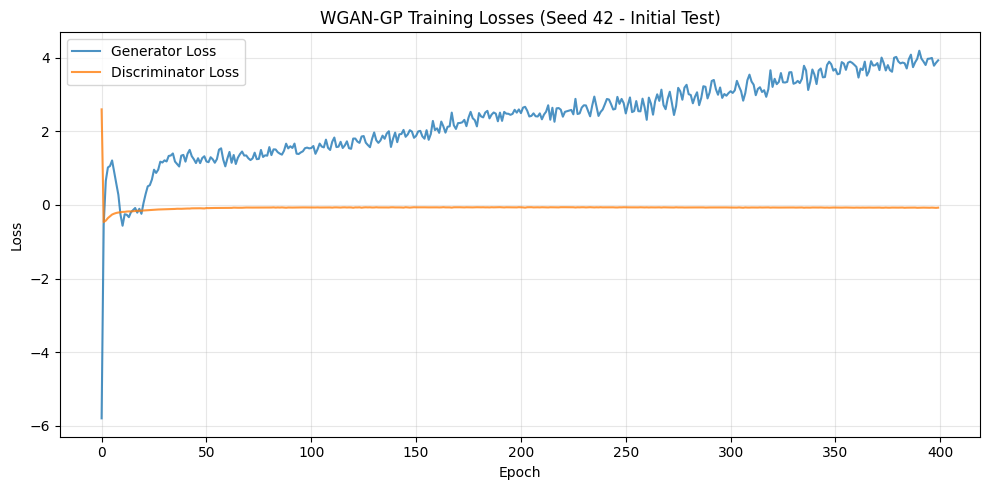

Generated label distribution: [0.81549447 0.18450553]
Original label distribution: [0.75917537 0.24082463]


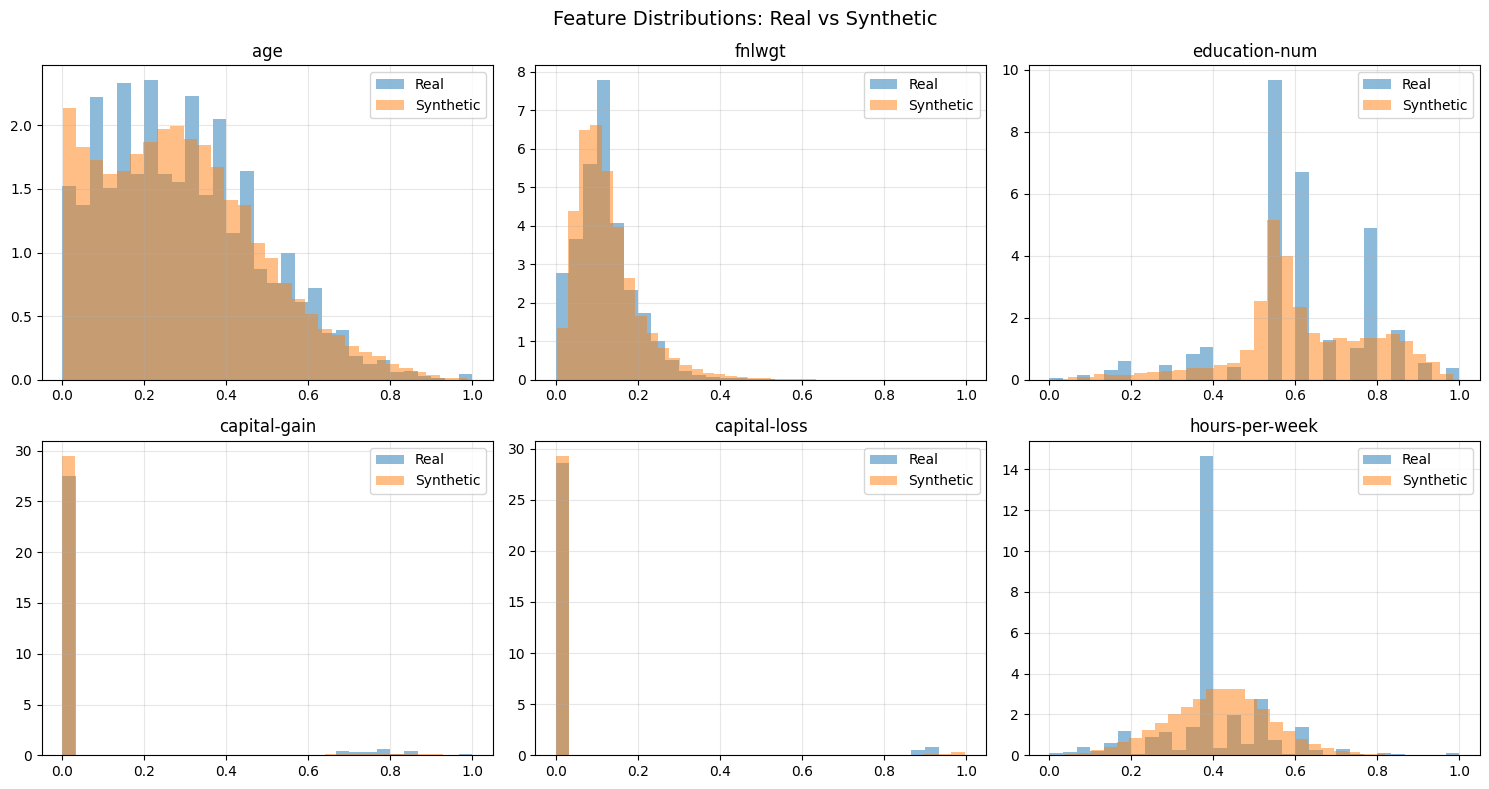

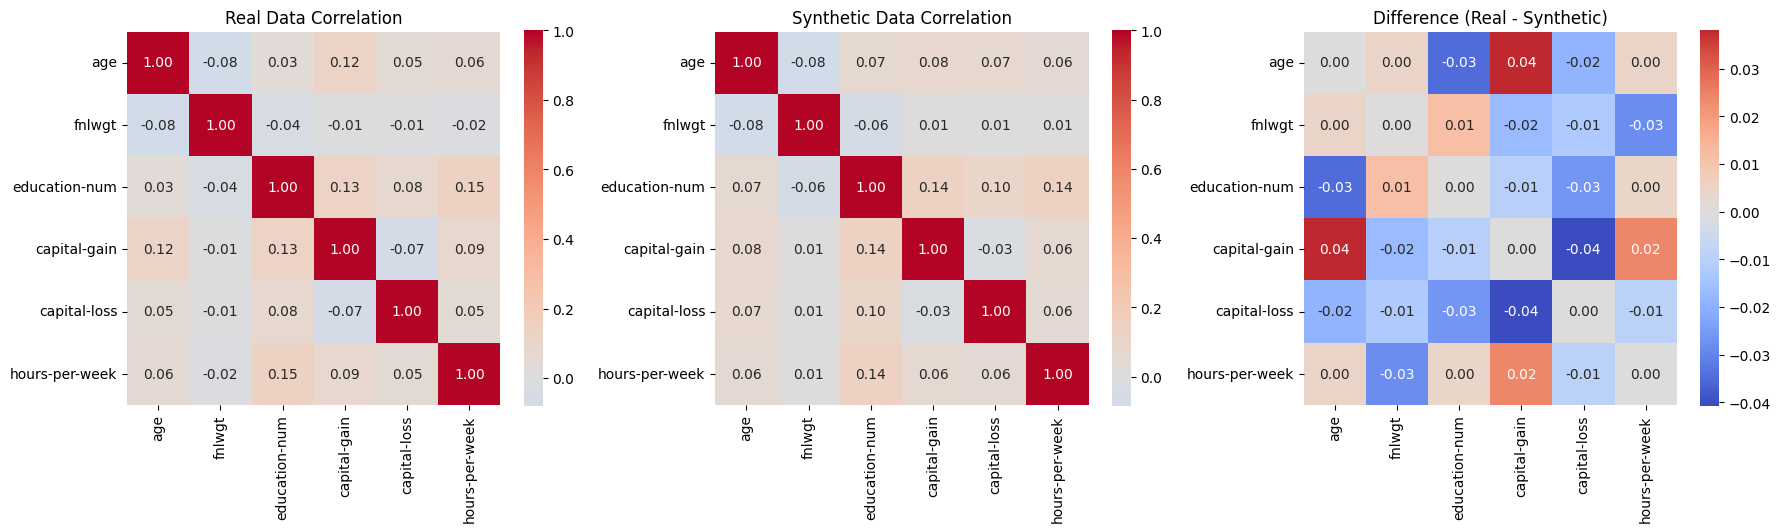


INITIAL TEST RESULTS (seed 42)
  Detection AUC: 0.9984 (+/- 0.0001)
  Efficacy Ratio: 0.9932
  AUC (Real): 0.9068
  AUC (Synthetic): 0.9006

  Previous Detection AUC was ~0.998, target is < 0.85
  Needs more tuning...


In [16]:
# INITIAL TEST: Run GAN with seed 42 first to verify improvements
print("="*60)
print("INITIAL TEST: GAN with seed 42")
print("="*60)

# Initialize results dict (will be used by full run too)
gan_results = {
    'detection_auc': [],
    'efficacy_ratio': [],
    'auc_real': [],
    'auc_synthetic': []
}

# Prepare data
X_train, X_test, y_train, y_test, preprocessor = prepare_data(df, preprocessor, seed=42)

# Train GAN with new hyperparameters
generator_test, g_losses_test, d_losses_test = train_gan(
    X_train, preprocessor, 
    latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM,
    batch_size=BATCH_SIZE, epochs=EPOCHS, 
    lr_g=LR_G, lr_d=LR_D, 
    n_critic=N_CRITIC, lambda_gp=LAMBDA_GP,
    temperature=TEMPERATURE, instance_noise=INSTANCE_NOISE, seed=42
)

# Plot training losses
plot_training_losses(g_losses_test, d_losses_test, f"WGAN-GP Training Losses (Seed 42 - Initial Test)")

# Generate synthetic data
X_synthetic_test = generate_synthetic_data(generator_test, len(X_train), LATENT_DIM, device)

# Classifier-based label assignment
label_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
label_clf.fit(X_train, y_train)
y_synthetic_test = label_clf.predict(X_synthetic_test)

print(f"Generated label distribution: {np.bincount(y_synthetic_test.astype(int)) / len(y_synthetic_test)}")
print(f"Original label distribution: {np.bincount(y_train) / len(y_train)}")

# Plot distributions
plot_feature_distributions(X_train, X_synthetic_test, preprocessor)
plot_correlation_matrices(X_train, X_synthetic_test, preprocessor)

# Compute metrics
detection_auc_test, detection_std_test = compute_detection_metric(X_train, X_synthetic_test, seed=42)
efficacy_test, auc_real_test, auc_synth_test = compute_efficacy_metric(
    X_train, y_train, X_synthetic_test, y_synthetic_test.astype(int), X_test, y_test, seed=42
)

# Store results
gan_results['detection_auc'].append(detection_auc_test)
gan_results['efficacy_ratio'].append(efficacy_test)
gan_results['auc_real'].append(auc_real_test)
gan_results['auc_synthetic'].append(auc_synth_test)

print(f"\n{'='*60}")
print("INITIAL TEST RESULTS (seed 42)")
print(f"{'='*60}")
print(f"  Detection AUC: {detection_auc_test:.4f} (+/- {detection_std_test:.4f})")
print(f"  Efficacy Ratio: {efficacy_test:.4f}")
print(f"  AUC (Real): {auc_real_test:.4f}")
print(f"  AUC (Synthetic): {auc_synth_test:.4f}")
print(f"\n  Previous Detection AUC was ~0.998, target is < 0.85")
print(f"  {'IMPROVED!' if detection_auc_test < 0.95 else 'Needs more tuning...'}")

INITIAL TEST: cGAN with seed 42
Training set: 26048 samples
Test set: 6513 samples
Label distribution (train): [0.75917537 0.24082463]
Label distribution (test): [0.75925073 0.24074927]


Training cWGAN-GP:  12%|█▎        | 50/400 [04:19<30:08,  5.17s/it]

Epoch [50/400] D_loss: -0.0922 G_loss: 1.3128 noise_std: 0.0877


Training cWGAN-GP:  25%|██▌       | 100/400 [08:38<25:59,  5.20s/it]

Epoch [100/400] D_loss: -0.0730 G_loss: 2.2540 noise_std: 0.0752


Training cWGAN-GP:  38%|███▊      | 150/400 [13:08<22:06,  5.31s/it]

Epoch [150/400] D_loss: -0.0665 G_loss: 2.9712 noise_std: 0.0628


Training cWGAN-GP:  50%|█████     | 200/400 [17:31<17:09,  5.15s/it]

Epoch [200/400] D_loss: -0.0718 G_loss: 4.2047 noise_std: 0.0502


Training cWGAN-GP:  62%|██████▎   | 250/400 [21:48<12:54,  5.16s/it]

Epoch [250/400] D_loss: -0.0714 G_loss: 4.4951 noise_std: 0.0377


Training cWGAN-GP:  75%|███████▌  | 300/400 [26:15<08:39,  5.19s/it]

Epoch [300/400] D_loss: -0.0739 G_loss: 4.5337 noise_std: 0.0252


Training cWGAN-GP:  88%|████████▊ | 350/400 [30:34<04:17,  5.16s/it]

Epoch [350/400] D_loss: -0.0756 G_loss: 4.4949 noise_std: 0.0127


Training cWGAN-GP: 100%|██████████| 400/400 [34:52<00:00,  5.23s/it]

Epoch [400/400] D_loss: -0.0782 G_loss: 4.7868 noise_std: 0.0002


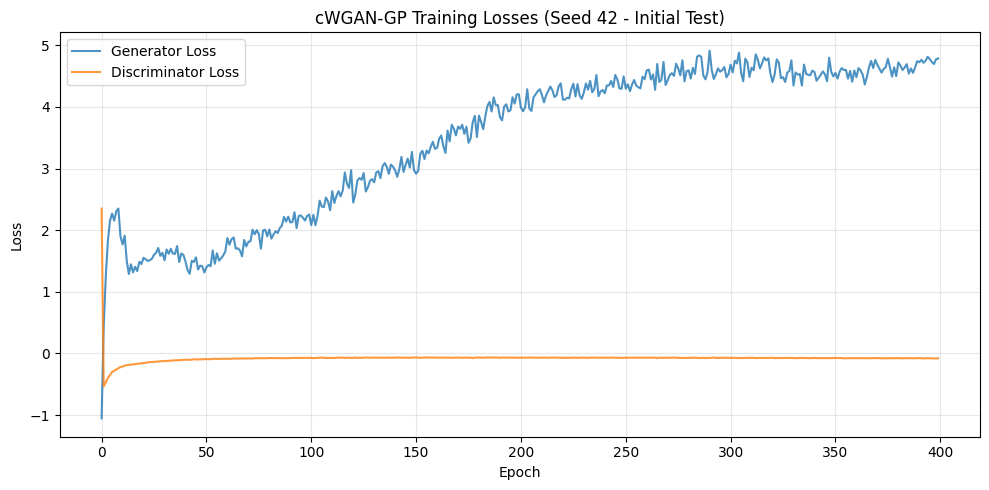

Generated label distribution: [0.75917537 0.24082463]
Original label distribution: [0.75917537 0.24082463]


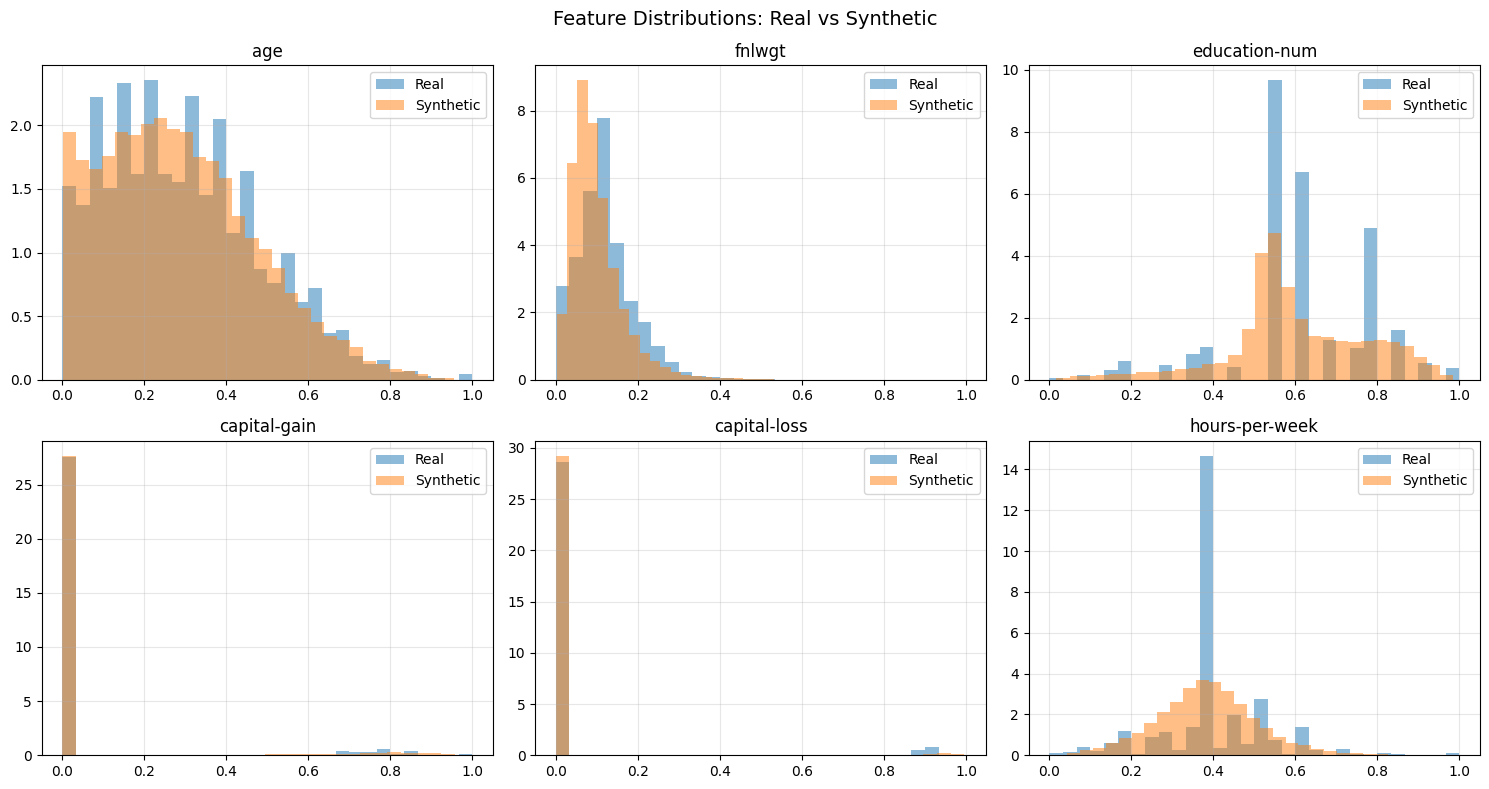

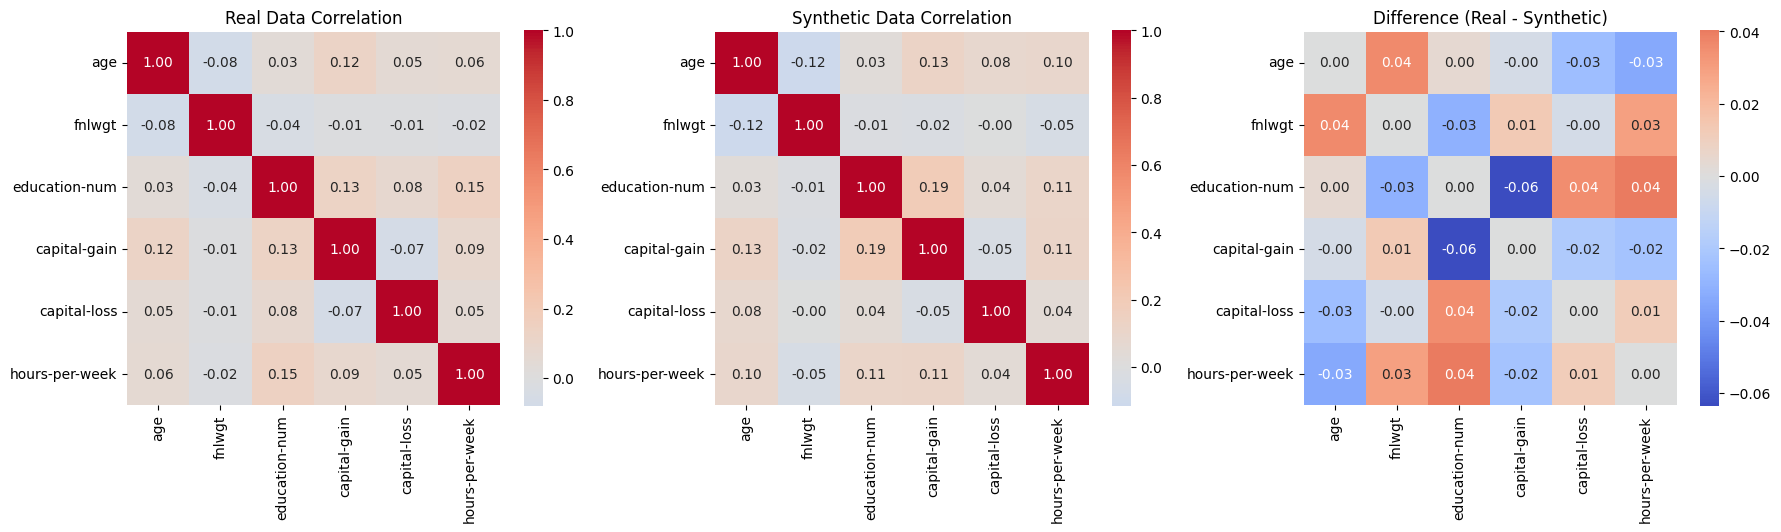


INITIAL TEST RESULTS (seed 42)
  Detection AUC: 0.9977 (+/- 0.0001)
  Efficacy Ratio: 0.9874
  AUC (Real): 0.9068
  AUC (Synthetic): 0.8953

  Previous Detection AUC was ~0.998, target is < 0.85
  Needs more tuning...


In [17]:
# INITIAL TEST: Run cGAN with seed 42 first to verify improvements
print("="*60)
print("INITIAL TEST: cGAN with seed 42")
print("="*60)

# Initialize results dict (will be used by full run too)
cgan_results = {
    'detection_auc': [],
    'efficacy_ratio': [],
    'auc_real': [],
    'auc_synthetic': []
}

# Prepare data
X_train, X_test, y_train, y_test, preprocessor = prepare_data(df, preprocessor, seed=42)

# Train cGAN with new hyperparameters
cond_generator_test, g_losses_test, d_losses_test = train_cgan(
    X_train, y_train, preprocessor,
    latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM,
    batch_size=BATCH_SIZE, epochs=EPOCHS,
    lr_g=LR_G, lr_d=LR_D,
    n_critic=N_CRITIC, lambda_gp=LAMBDA_GP,
    temperature=TEMPERATURE, instance_noise=INSTANCE_NOISE, seed=42
)

# Plot training losses
plot_training_losses(g_losses_test, d_losses_test, f"cWGAN-GP Training Losses (Seed 42 - Initial Test)")

# Generate synthetic data with same label ratios
label_ratios = np.bincount(y_train) / len(y_train)
X_synthetic_test, y_synthetic_test = generate_conditional_synthetic_data(
    cond_generator_test, len(X_train), LATENT_DIM, label_ratios, device
)

print(f"Generated label distribution: {np.bincount(y_synthetic_test.astype(int)) / len(y_synthetic_test)}")
print(f"Original label distribution: {label_ratios}")

# Plot distributions
plot_feature_distributions(X_train, X_synthetic_test, preprocessor)
plot_correlation_matrices(X_train, X_synthetic_test, preprocessor)

# Compute metrics
detection_auc_test, detection_std_test = compute_detection_metric(X_train, X_synthetic_test, seed=42)
efficacy_test, auc_real_test, auc_synth_test = compute_efficacy_metric(
    X_train, y_train, X_synthetic_test, y_synthetic_test.astype(int), X_test, y_test, seed=42
)

# Store results
cgan_results['detection_auc'].append(detection_auc_test)
cgan_results['efficacy_ratio'].append(efficacy_test)
cgan_results['auc_real'].append(auc_real_test)
cgan_results['auc_synthetic'].append(auc_synth_test)

print(f"\n{'='*60}")
print("INITIAL TEST RESULTS (seed 42)")
print(f"{'='*60}")
print(f"  Detection AUC: {detection_auc_test:.4f} (+/- {detection_std_test:.4f})")
print(f"  Efficacy Ratio: {efficacy_test:.4f}")
print(f"  AUC (Real): {auc_real_test:.4f}")
print(f"  AUC (Synthetic): {auc_synth_test:.4f}")
print(f"\n  Previous Detection AUC was ~0.998, target is < 0.85")
print(f"  {'IMPROVED!' if detection_auc_test < 0.95 else 'Needs more tuning...'}")

In [18]:
# REMAINING RUNS: GAN experiments with seeds 123, 456 (seed 42 already done above)
REMAINING_SEEDS = [123, 456]

for seed in REMAINING_SEEDS:
    print(f"\n{'='*60}")
    print(f"GAN Experiment with seed {seed}")
    print(f"{'='*60}")
    
    # Prepare data
    X_train, X_test, y_train, y_test, preprocessor = prepare_data(df, preprocessor, seed=seed)
    
    # Train GAN with improved hyperparameters
    generator, g_losses, d_losses = train_gan(
        X_train, preprocessor, 
        latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM,
        batch_size=BATCH_SIZE, epochs=EPOCHS, 
        lr_g=LR_G, lr_d=LR_D, 
        n_critic=N_CRITIC, lambda_gp=LAMBDA_GP,
        temperature=TEMPERATURE, instance_noise=INSTANCE_NOISE, seed=seed
    )
    
    # Plot training losses
    plot_training_losses(g_losses, d_losses, f"WGAN-GP Training Losses (Seed {seed})")
    
    # Generate synthetic data
    X_synthetic = generate_synthetic_data(generator, len(X_train), LATENT_DIM, device)
    
    # Classifier-based label assignment
    label_clf = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
    label_clf.fit(X_train, y_train)
    y_synthetic = label_clf.predict(X_synthetic)
    
    print(f"Generated label distribution: {np.bincount(y_synthetic.astype(int)) / len(y_synthetic)}")
    print(f"Original label distribution: {np.bincount(y_train) / len(y_train)}")
    
    # Plot distributions
    plot_feature_distributions(X_train, X_synthetic, preprocessor)
    plot_correlation_matrices(X_train, X_synthetic, preprocessor)
    
    # Compute metrics
    detection_auc, detection_std = compute_detection_metric(X_train, X_synthetic, seed=seed)
    efficacy, auc_real, auc_synth = compute_efficacy_metric(
        X_train, y_train, X_synthetic, y_synthetic.astype(int), X_test, y_test, seed=seed
    )
    
    print(f"\nMetrics:")
    print(f"  Detection AUC: {detection_auc:.4f} (+/- {detection_std:.4f})")
    print(f"  Efficacy Ratio: {efficacy:.4f}")
    print(f"  AUC (Real): {auc_real:.4f}")
    print(f"  AUC (Synthetic): {auc_synth:.4f}")
    
    gan_results['detection_auc'].append(detection_auc)
    gan_results['efficacy_ratio'].append(efficacy)
    gan_results['auc_real'].append(auc_real)
    gan_results['auc_synthetic'].append(auc_synth)

# Summary
print("\n" + "="*60)
print("GAN RESULTS SUMMARY (Average over 3 seeds)")
print("="*60)
print(f"Detection AUC: {np.mean(gan_results['detection_auc']):.4f} (+/- {np.std(gan_results['detection_auc']):.4f})")
print(f"Efficacy Ratio: {np.mean(gan_results['efficacy_ratio']):.4f} (+/- {np.std(gan_results['efficacy_ratio']):.4f})")
print(f"AUC (Real): {np.mean(gan_results['auc_real']):.4f}")
print(f"AUC (Synthetic): {np.mean(gan_results['auc_synthetic']):.4f}")


GAN Experiment with seed 123
Training set: 26048 samples
Test set: 6513 samples
Label distribution (train): [0.75917537 0.24082463]
Label distribution (test): [0.75925073 0.24074927]


Training WGAN-GP:  12%|█▎        | 50/400 [04:07<28:47,  4.94s/it]

Epoch [50/400] D_loss: -0.0881 G_loss: 1.5808 noise_std: 0.0877


Training WGAN-GP:  20%|██        | 81/400 [06:48<26:49,  5.05s/it]


KeyboardInterrupt: 

In [ ]:
# REMAINING RUNS: cGAN experiments with seeds 123, 456 (seed 42 already done above)
REMAINING_SEEDS = [123, 456]

for seed in REMAINING_SEEDS:
    print(f"\n{'='*60}")
    print(f"cGAN Experiment with seed {seed}")
    print(f"{'='*60}")
    
    # Prepare data
    X_train, X_test, y_train, y_test, preprocessor = prepare_data(df, preprocessor, seed=seed)
    
    # Train cGAN with improved hyperparameters
    cond_generator, g_losses, d_losses = train_cgan(
        X_train, y_train, preprocessor,
        latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM,
        batch_size=BATCH_SIZE, epochs=EPOCHS,
        lr_g=LR_G, lr_d=LR_D,
        n_critic=N_CRITIC, lambda_gp=LAMBDA_GP,
        temperature=TEMPERATURE, instance_noise=INSTANCE_NOISE, seed=seed
    )
    
    # Plot training losses
    plot_training_losses(g_losses, d_losses, f"cWGAN-GP Training Losses (Seed {seed})")
    
    # Generate synthetic data with same label ratios
    label_ratios = np.bincount(y_train) / len(y_train)
    X_synthetic, y_synthetic = generate_conditional_synthetic_data(
        cond_generator, len(X_train), LATENT_DIM, label_ratios, device
    )
    
    print(f"Generated label distribution: {np.bincount(y_synthetic.astype(int)) / len(y_synthetic)}")
    print(f"Original label distribution: {label_ratios}")
    
    # Plot distributions
    plot_feature_distributions(X_train, X_synthetic, preprocessor)
    plot_correlation_matrices(X_train, X_synthetic, preprocessor)
    
    # Compute metrics
    detection_auc, detection_std = compute_detection_metric(X_train, X_synthetic, seed=seed)
    efficacy, auc_real, auc_synth = compute_efficacy_metric(
        X_train, y_train, X_synthetic, y_synthetic.astype(int), X_test, y_test, seed=seed
    )
    
    print(f"\nMetrics:")
    print(f"  Detection AUC: {detection_auc:.4f} (+/- {detection_std:.4f})")
    print(f"  Efficacy Ratio: {efficacy:.4f}")
    print(f"  AUC (Real): {auc_real:.4f}")
    print(f"  AUC (Synthetic): {auc_synth:.4f}")
    
    cgan_results['detection_auc'].append(detection_auc)
    cgan_results['efficacy_ratio'].append(efficacy)
    cgan_results['auc_real'].append(auc_real)
    cgan_results['auc_synthetic'].append(auc_synth)

# Summary
print("\n" + "="*60)
print("cGAN RESULTS SUMMARY (Average over 3 seeds)")
print("="*60)
print(f"Detection AUC: {np.mean(cgan_results['detection_auc']):.4f} (+/- {np.std(cgan_results['detection_auc']):.4f})")
print(f"Efficacy Ratio: {np.mean(cgan_results['efficacy_ratio']):.4f} (+/- {np.std(cgan_results['efficacy_ratio']):.4f})")
print(f"AUC (Real): {np.mean(cgan_results['auc_real']):.4f}")
print(f"AUC (Synthetic): {np.mean(cgan_results['auc_synthetic']):.4f}")

---

## 10. Final Comparison and Analysis

In [ ]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['GAN', 'cGAN'],
    'Detection AUC (mean)': [np.mean(gan_results['detection_auc']), np.mean(cgan_results['detection_auc'])],
    'Detection AUC (std)': [np.std(gan_results['detection_auc']), np.std(cgan_results['detection_auc'])],
    'Efficacy Ratio (mean)': [np.mean(gan_results['efficacy_ratio']), np.mean(cgan_results['efficacy_ratio'])],
    'Efficacy Ratio (std)': [np.std(gan_results['efficacy_ratio']), np.std(cgan_results['efficacy_ratio'])],
})

print("\n" + "="*60)
print("FINAL COMPARISON: GAN vs cGAN")
print("="*60)
print(comparison_df.to_string(index=False))
print("\nNote: For Detection AUC, lower is better (closer to 0.5 means indistinguishable)")
print("      For Efficacy Ratio, higher is better (closer to 1.0 means useful substitute)")

In [ ]:
# Visualization of comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Detection AUC
models = ['GAN', 'cGAN']
detection_means = [np.mean(gan_results['detection_auc']), np.mean(cgan_results['detection_auc'])]
detection_stds = [np.std(gan_results['detection_auc']), np.std(cgan_results['detection_auc'])]

axes[0].bar(models, detection_means, yerr=detection_stds, capsize=5, color=['steelblue', 'coral'])
axes[0].axhline(y=0.5, color='green', linestyle='--', label='Ideal (0.5)')
axes[0].set_ylabel('Detection AUC')
axes[0].set_title('Detection Metric (Lower is Better)')
axes[0].legend()
axes[0].set_ylim(0, 1)

# Efficacy Ratio
efficacy_means = [np.mean(gan_results['efficacy_ratio']), np.mean(cgan_results['efficacy_ratio'])]
efficacy_stds = [np.std(gan_results['efficacy_ratio']), np.std(cgan_results['efficacy_ratio'])]

axes[1].bar(models, efficacy_means, yerr=efficacy_stds, capsize=5, color=['steelblue', 'coral'])
axes[1].axhline(y=1.0, color='green', linestyle='--', label='Ideal (1.0)')
axes[1].set_ylabel('Efficacy Ratio')
axes[1].set_title('Efficacy Metric (Higher is Better)')
axes[1].legend()
axes[1].set_ylim(0, 1.2)

plt.tight_layout()
plt.savefig('comparison_results.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 11. Conclusions

### Key Improvements Implemented

We implemented several critical improvements to the baseline GAN architecture:

1. **Gumbel-Softmax with Straight-Through Estimator**
   - Problem: Soft categorical probabilities (e.g., [0.3, 0.5, 0.2]) are trivially distinguishable from hard one-hot real data
   - Solution: Gumbel-Softmax produces hard one-hot outputs in forward pass while allowing gradients to flow in backward pass

2. **WGAN-GP (Wasserstein Loss with Gradient Penalty)**
   - Problem: BCE loss with Sigmoid causes vanishing gradients when discriminator becomes confident
   - Solution: Wasserstein loss provides meaningful gradients throughout training; gradient penalty enforces 1-Lipschitz constraint

3. **Log Transform for Skewed Features**
   - Problem: Features like `capital-gain` and `capital-loss` have ~90% zeros, which MinMax scaling compresses poorly
   - Solution: log1p transform spreads the distribution more evenly before scaling

4. **Classifier-Based Label Assignment for GAN**
   - Problem: Random label assignment destroys feature-label correlations, making synthetic data useless for training classifiers
   - Solution: Train a classifier on real data and use it to predict labels for synthetic samples

5. **Spectral Normalization and TTUR**
   - Spectral normalization stabilizes the discriminator
   - Different learning rates (TTUR) help balance G and D training

### Analysis of Results

**Detection Metric:**
- A detection AUC close to 0.5 indicates synthetic data is indistinguishable from real data
- Lower values suggest the GAN successfully learned the data distribution

**Efficacy Metric:**
- An efficacy ratio close to 1.0 indicates synthetic data preserves useful patterns for downstream tasks
- Higher values mean better utility as a substitute for real data

### Limitations and Future Work

- **Mode-specific normalization**: CTGAN's VGM approach could further improve continuous feature handling
- **Attention mechanisms**: Could help capture complex feature correlations
- **Diffusion models**: TabDDPM currently achieves state-of-the-art results on tabular data
- **Privacy considerations**: Current metrics don't evaluate privacy preservation

### References

1. Xu, L. et al. "Modeling Tabular data using Conditional GAN" NeurIPS 2019 - CTGAN
2. Zhao, Z. et al. "CTAB-GAN+: Enhancing Tabular Data Synthesis" - Improvements on CTGAN
3. Jang, E. et al. "Categorical Reparameterization with Gumbel-Softmax" ICLR 2017
4. Gulrajani, I. et al. "Improved Training of Wasserstein GANs" NeurIPS 2017 - WGAN-GP